In [1]:
using Turing
using LimberJack
using LinearAlgebra
using CSV
using NPZ
using Plots
using FITSIO
using ForwardDiff
using BenchmarkTools
using DelimitedFiles

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423


In [2]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [3]:
cov_tot = files["cov"]
inv_cov_tot = files["inv_cov"]
data_vector = files["cls"];

In [25]:
nzs = files["nz_11"]
zs = vec(nzs[1:1, :])

400-element Vector{Float64}:
 0.0051
 0.015099999999999999
 0.0251
 0.035100000000000006
 0.0451
 0.0551
 0.0651
 0.07510000000000001
 0.0851
 0.0951
 0.10510000000000001
 0.1151
 0.1251
 ⋮
 3.8851
 3.8951000000000002
 3.9051000000000005
 3.9151000000000002
 3.9251
 3.9351000000000003
 3.9451000000000005
 3.9551000000000003
 3.9651
 3.9751000000000003
 3.9851000000000005
 3.9951000000000003

In [26]:
zs

0.0051

In [4]:
#                Omega_b,           Omega_c          n_s,                 h,
#                DESgc__0_gc_b,     DESgc__1_gc_b,   DESgc__2_gc_b,    DESgc__3_gc_b,    DESgc__4_gc_b,
#                DESgc__0_dz,      DESgc__1_dz,      DESgc__2_dz,      DESgc__3_dz,      DESgc__4_dz,
#                wl_ia_A,          wl_ia_eta, 
#                DESwl__0_wl_m,    DESwl__1_wl_m,    DESwl__2_wl_m,    DESwl__3_wl_m,
#                DESwl__0_dz,      DESwl__1_dz,      DESwl__2_dz,      DESwl__3_dz,
#                sigma_8,          Omega_m
carlos_params1 = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
                 1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
                -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
                 2.389208e-01,   -6.435288e-01, 
                 1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
                -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
                 8.536883e-01,    2.535825e-01];

In [5]:
cls_carlos = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info.npz");
cls_carlos2 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp.npz");
cls_carlos3 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH.npz");
cls_carlos4 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH_noconv.npz");

In [6]:
pars = carlos_params1
nuisances = Dict("b0" => pars[5],
                 "b1" => pars[6],
                 "b2" => pars[7],
                 "b3" => pars[8],
                 "b4" => pars[9],
                 "dz_g0" => pars[10],
                 "dz_g1" => pars[11],
                 "dz_g2" => pars[12],
                 "dz_g3" => pars[13],
                 "dz_g4" => pars[14],
                 "dz_k0" => pars[21],
                 "dz_k1" => pars[22],
                 "dz_k2" => pars[23],
                 "dz_k3" => pars[24],
                 "m0" => pars[17],
                 "m1" => pars[18],
                 "m2" => pars[19],
                 "m3" => pars[20],
                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16]);

In [31]:
function make_cls(pars)
    nuisances = Dict("b0" => pars[5],
                     "b1" => pars[6],
                     "b2" => pars[7],
                     "b3" => pars[8],
                     "b4" => pars[9],
                     "dz_g0" => pars[10],
                     "dz_g1" => pars[11],
                     "dz_g2" => pars[12],
                     "dz_g3" => pars[13],
                     "dz_g4" => pars[14],
                     "dz_k0" => pars[21],
                     "dz_k1" => pars[22],
                     "dz_k2" => pars[23],
                     "dz_k3" => pars[24],
                     "m0" => pars[17],
                     "m1" => pars[18],
                     "m2" => pars[19],
                     "m3" => pars[20],
                     "A_IA" => pars[15],
                     "alpha_IA" => pars[16])

    Ωm = pars[26]
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = pars[25]
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu", Pk_mode="Halofit")#, 
                                     #nk=500, nz=500, nz_pk=500)

    return Theory(cosmology, nuisances, Cls_meta, files).cls

end

make_cls (generic function with 1 method)

In [8]:
function diff_cls_nuisance(dz)
    nuisance = Dict("dz_g0"=> dz)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cls = Theory(cosmology, nuisances, Cls_meta, files).cls
    return cls
end

function numd_cls_nuisance(dz)
    nuisances1 = Dict("dz_g0"=> dz)
    nuisances2 = Dict("dz_g0"=> dz-0.0005)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81,
                                     tk_mode="EisHu", Pk_mode="Halofit")
    cls1 = Theory(cosmology, nuisances1, Cls_meta, files).cls
    cls2 = Theory(cosmology, nuisances2, Cls_meta, files).cls
    return (cls1-cls2)/0.0005
end

function diff_tracer_nuisance(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    zs_shift = zs .- dz
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    tracer = WeakLensingTracer(cosmology, zs_shift, nz)
    #w1 = tracer.warr
    w1 = tracer.wint(tracer.chis)
    return w1
end

function numd_tracer_nuisance(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    zs_shift = zs .- dz
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    tracer1 = WeakLensingTracer(cosmology, zs_shift, nz)
    tracer2 = WeakLensingTracer(cosmology, zs_shift .- 0.0005, nz)
    #w1 = tracer1.warr
    w1 = tracer1.wint(tracer1.chis)
    #w2 = tracer2.warr
    w2 = tracer2.wint(tracer2.chis)
    return (w2 .- w1) ./ 0.0005
end

function diff_cls2_nuisance(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    ls = files["ls_1010"]
    zs_shift = zs .- dz
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    tracer1 = WeakLensingTracer(cosmology, zs_shift, nz)
    tracer2 = NumberCountsTracer(cosmology, zs_shift, nz)
    Cls = angularCℓs(cosmology, tracer2, tracer2, ls)
    return Cls
end

function numd_cls2_nuisance(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    ls = files["ls_1010"]
    zs_shift = zs .- dz
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    tracer1 = WeakLensingTracer(cosmology, zs_shift, nz)
    tracer2 = NumberCountsTracer(cosmology, zs_shift, nz)
    tracer3 = WeakLensingTracer(cosmology, zs_shift .- 0.0005, nz)
    tracer4 = NumberCountsTracer(cosmology, zs_shift .- 0.0005, nz)
    Cls1 = angularCℓs(cosmology, tracer2, tracer2, ls)
    Cls2 = angularCℓs(cosmology, tracer4, tracer4, ls)
    return (Cls2 .- Cls1) ./ 0.0005
end



numd_cls2_nuisance (generic function with 1 method)

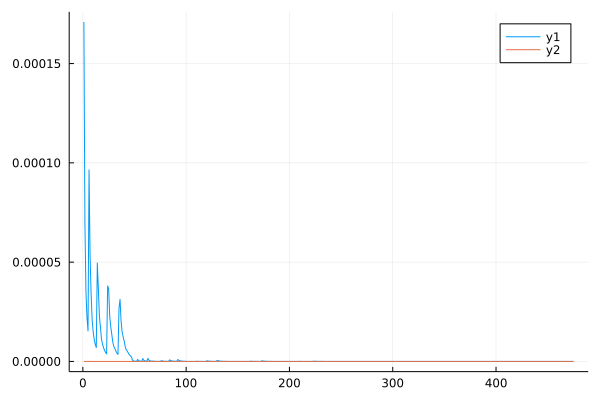

In [9]:
plot(diff_cls_nuisance(-0.1))
plot!(ForwardDiff.derivative(diff_cls_nuisance, -0.1))

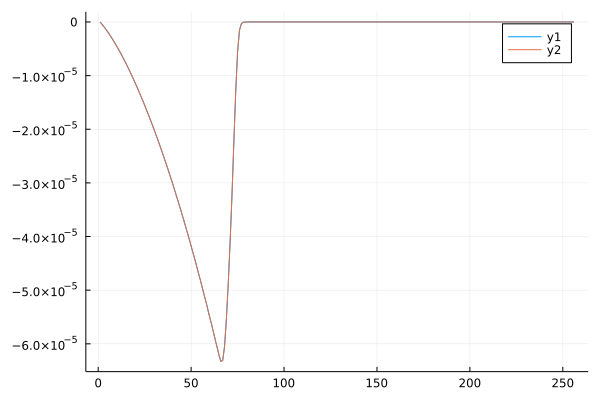

In [10]:
plot(ForwardDiff.derivative(diff_tracer_nuisance, -1))
plot!(numd_tracer_nuisance(-1) )

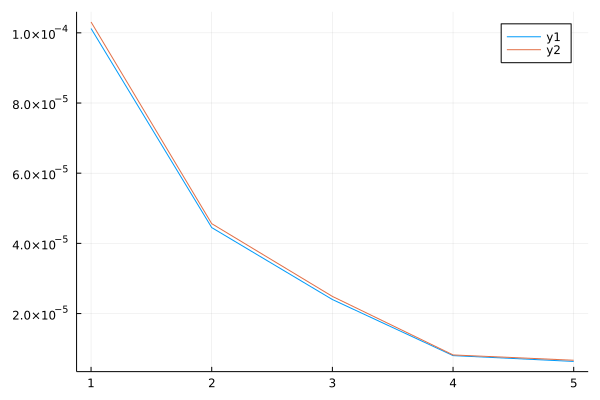

In [11]:
plot(ForwardDiff.derivative(diff_cls2_nuisance, -0.1))
plot!(numd_cls2_nuisance(-0.1))

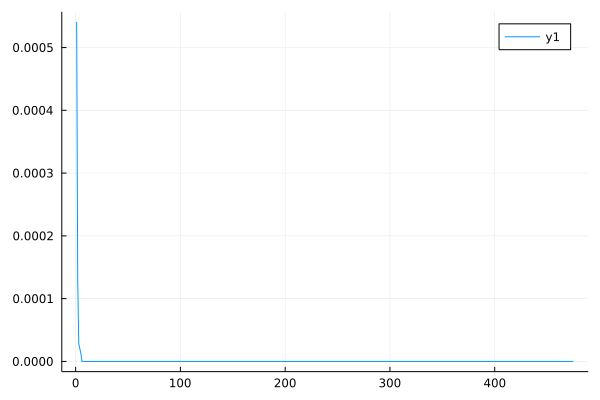

In [12]:
plot(numd_cls_nuisance(-0.01))

In [13]:
using Interpolations
function test_func(dz; nzs=files["nz_11"])
    nz = vec(nzs[2:2, :])
    zs = vec(nzs[1:1, :])
    zs_shift = zs .- dz
    nz_int = LinearInterpolation(zs_shift, nz, extrapolation_bc=0)
    res = 200
    z_w = range(0.00001, stop=zs_shift[end], length=res)
    dz_w = (z_w[end]-z_w[1])/res
    nz_w = nz_int(z_w)
    nz_norm = sum(0.5 .* (nz_w[1:res-1] .+ nz_w[2:res]) .* dz_w)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    return cosmology.chi(z_w) .* nz_norm #(zs .^2) .* nz_norm
end

function numd_test_func(dz)
    v1 = test_func(dz)
    v2 = test_func(dz-0.0005)
    return (v1-v2)/0.0005
end

numd_test_func (generic function with 1 method)

In [14]:
diff1 = ForwardDiff.derivative(test_func, -0.01) 

200-element Vector{Float64}:
    0.013644162200570941
    5.280798980091223
   10.78342510846683
   16.527814487869932
   22.011921292758586
   28.098779750368365
   34.43693675511406
   40.14780733232979
   46.83638405413038
   53.77826136094805
   60.97235813424561
   67.00698809835984
   74.54552079680562
    ⋮
 1328.7627116881813
 1329.9353671065041
 1331.1080225248277
 1332.2806779431507
 1333.453333361474
 1334.625988779797
 1335.7986441981207
 1336.971299616444
 1338.1439550347668
 1339.3166104530899
 1340.4892658714134
 1341.6619212897367

In [15]:
diff2 = numd_test_func(-0.01)

200-element Vector{Float64}:
    0.013647245780304407
    5.290404904854995
   10.802504261050672
   16.556235353505144
   22.049623573934696
   28.14557004035123
   34.49267961741498
   40.21250133951071
   46.90977164182186
   53.8602053240993
   61.062721176540435
   67.10584399343134
   74.65253533018767
    ⋮
 1329.4209500909346
 1330.5957744541956
 1331.7705988192756
 1332.9454231843556
 1334.1202475494356
 1335.2950719126966
 1336.4698962777766
 1337.6447206446755
 1338.8195450061176
 1339.9943693711975
 1341.1691937362775
 1342.3440180995385

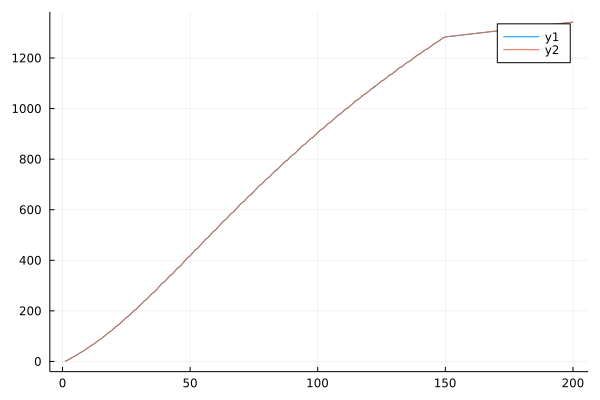

In [16]:
plot(diff1)
plot!(diff2)

In [32]:
cls_jaime1 = make_cls(carlos_params1);

In [33]:
open("jaime_cls.txt", "w") do io
       writedlm(io, cls_jaime1)
end

In [34]:
compa1 = @. abs(cls_carlos["cls"]-cls_jaime1)/cls_carlos["cls"];
compa2 = @. abs(cls_carlos2["cls"]-cls_jaime1)/cls_carlos2["cls"];
compa3 = @. abs(cls_carlos3["cls"]-cls_jaime1)/cls_carlos3["cls"];
compa4 = @. abs(cls_carlos4["cls"]-cls_jaime1)/cls_carlos4["cls"];

println("Mean discrepancy default   ", mean(compa1))
println("Mean discrepancy no itp    ", mean(compa2))
println("Mean discrepancy no itp+EH ", mean(compa3))
println("Mean discrepancy no itp+EH+noconv ", mean(compa4))

Mean discrepancy default   0.024473264051032027
Mean discrepancy no itp    0.018542593775196434
Mean discrepancy no itp+EH 0.013261826849274112
Mean discrepancy no itp+EH+noconv 0.008923164822374404


In [35]:
chi2_carlos = cls_carlos["chi2_nolp"]
chi2_carlos2 = cls_carlos2["chi2_nolp"]
chi2_carlos3 = cls_carlos3["chi2_nolp"]
chi2_carlos4 = cls_carlos4["chi2_nolp"]
println(chi2_carlos)
println(chi2_carlos2)
println(chi2_carlos3)
println(chi2_carlos4)

495.62231927779936
495.00947244084654
495.89420547809317
497.2051355000593


In [36]:
chi2_jaime1 = dot((cls_jaime1 .- data_vector), inv_cov_tot  * (cls_jaime1 .- data_vector))
println(chi2_jaime1)

498.422930572849


In [37]:
(chi2_jaime1-chi2_carlos4)/chi2_carlos4

0.0024492809624037455

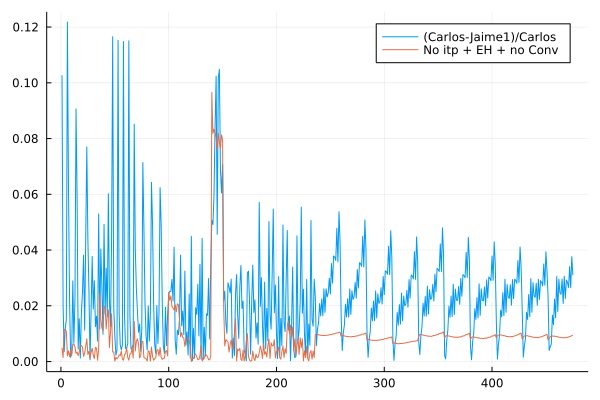

In [38]:
plot(compa1, label="(Carlos-Jaime1)/Carlos")
plot!(compa4, label="No itp + EH + no Conv")

In [27]:
@model function model(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.6)
    Ωb = 0.05 #~ Uniform(0.03, 0.07)
    h = 0.67 #~ Uniform(0.6, 0.9)
    s8 = 0.81 #~ Uniform(0.6, 1.0)
    ns = 0.96 #~ Uniform(0.87, 1.07)
    
    #b0 ~ Uniform(0.8, 3.0)
    #b1 ~ Uniform(0.8, 3.0)
    #b2 ~ Uniform(0.8, 3.0)
    #b3 ~ Uniform(0.8, 3.0)
    #b4 ~ Uniform(0.8, 3.0)
    
    dz_g0 ~ TruncatedNormal(0.008, 0.007, -2.0, 2.0)
    dz_g1 ~ TruncatedNormal(-0.005, 0.007, -2.0, 2.0)
    dz_g2 ~ TruncatedNormal(0.006, 0.006, -2.0, 2.0)
    dz_g3 ~ TruncatedNormal(0.0, 0.010, -2.0, 2.0)
    dz_g4 ~ TruncatedNormal(0.0, 0.010, -2.0, 2.0)
    
    #m0 ~ Normal(0.0, 0.035)
    #m1 ~ Normal(0.0, 0.035)
    #m2 ~ Normal(0.0, 0.035)
    #m3 ~ Normal(0.0, 0.035)
    
    #A_IA ~ Uniform(-5, 5) 
    #alpha_IA ~ Uniform(-5, 5)

    nuisances = Dict("dz_g0" => dz_g0,
                     "dz_g1" => dz_g1,
                     "dz_g2" => dz_g2,
                     "dz_g3" => dz_g3,
                     "dz_g4" => dz_g4)
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, s8, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, nuisances, Cls_meta, files).cls
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [28]:
iterations = 300
nadapts = 100;

In [29]:
chain1 = sample(model(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1m_broadcast_getindex_evalf[22m[0m[1m([22m::[0mInterpolations.Extrapolation[90m{Float64, 2, Interpolations.GriddedInterpolation{Float64, 2, Float64, Interpolations.Gridded{Interpolations.Linear}, Tuple{Vector{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, Interpolations.Gridded{Interpolations.Linear}, Interpolations.Throw{Nothing}}[39m, ::[0mFloat64, ::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:670[24m[39m
      [2] [0m[1m_broadcast_getindex[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:643[24m[39m[90m [inlined][39m
      [3] [0m[1m_getindex[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:667[24m[39m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(exp), Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, Interpolations.Extrapolation{Float64, 2, Interpolations.GriddedInterpolation{Float64, 2, Float64, Interpolations.Gridded{Interpolations.Linear}, Tuple{Vector{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, Interpolations.Gridded{Interpolations.Linear}, Interpolations.Throw{Nothing}}, Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(log), Tuple{Float64}}, Float64}}}}[39m, [90mI[39m::[0mCartesianIndex[90m{0}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:642[24m[39m
      [5] [0m[1mgetindex[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:597[24m[39m[90m [inlined][39m
      [6] [0m[1mcopy[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:875[24m[39m[90m [inlined][39m
      [7] [0m[1mmaterialize[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:860[24m[39m[90m [inlined][39m
      [8] [0m[1mnonlin_Pk[22m[0m[1m([22m[90mcosmo[39m::[0mCosmology, [90mk[39m::[0mFloat64, [90mz[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[35mLimberJack[39m [90m~/PhD/LimberJack.jl/src/[39m[90m[4mcore.jl:250[24m[39m
      [9] [0m[1mCℓintegrand[22m[0m[1m([22m[90mcosmo[39m::[0mCosmology, [90mt1[39m::[0mNumberCountsTracer, [90mt2[39m::[0mNumberCountsTracer, [90mlogk[39m::[0mFloat64, [90mℓ[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[35mLimberJack[39m [90m~/PhD/LimberJack.jl/src/[39m[90m[4mspectra.jl:14[24m[39m
     [10] [0m[1m(::LimberJack.var"#12#13"{Cosmology, NumberCountsTracer, NumberCountsTracer, Float64})[22m[0m[1m([22m[90mlogk[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[35mLimberJack[39m [90m./[39m[90m[4mnone:0[24m[39m
     [11] [0m[1miterate[22m
    [90m    @ [39m[90m./[39m[90m[4mgenerator.jl:47[24m[39m[90m [inlined][39m
     [12] [0m[1mcollect_to![22m[0m[1m([22m[90mdest[39m::[0mVector[90m{Float64}[39m, [90mitr[39m::[0mBase.Generator[90m{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, LimberJack.var"#12#13"{Cosmology, NumberCountsTracer, NumberCountsTracer, Float64}}[39m, [90moffs[39m::[0mInt64, [90mst[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4marray.jl:782[24m[39m
     [13] [0m[1mcollect_to_with_first![22m[0m[1m([22m[90mdest[39m::[0mVector[90m{Float64}[39m, [90mv1[39m::[0mFloat64, [90mitr[39m::[0mBase.Generator[90m{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, LimberJack.var"#12#13"{Cosmology, NumberCountsTracer, NumberCountsTracer, Float64}}[39m, [90mst[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4marray.jl:760[24m[39m
     [14] [0m[1mcollect[22m[0m[1m([22m[90mitr[39m::[0mBase.Generator[90m{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, LimberJack.var"#12#13"{Cosmology, NumberCountsTracer, NumberCountsTracer, Float64}}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4marray.jl:734[24m[39m
     [15] [0m[1mangularCℓs[22m[0m[1m([22m[90mcosmo[39m::[0mCosmology, [90mt1[39m::[0mNumberCountsTracer, [90mt2[39m::[0mNumberCountsTracer, [90mℓs[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mLimberJack[39m [90m~/PhD/LimberJack.jl/src/[39m[90m[4mspectra.jl:27[24m[39m
     [16] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m~/PhD/LimberJack.jl/src/[39m[90m[4mtheory.jl:214[24m[39m[90m [inlined][39m
     [17] [0m[1m(::LimberJack.var"#23#threadsfor_fun#32"{Cosmology, cls_meta{Vector{Vector{Int64}}}, Dict{String, Array}, Vector{Float64}, Vector{Int64}, Vector{Any}, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mLimberJack[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [18] [0m[1m(::LimberJack.var"#23#threadsfor_fun#32"{Cosmology, cls_meta{Vector{Vector{Int64}}}, Dict{String, Array}, Vector{Float64}, Vector{Int64}, Vector{Any}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mLimberJack[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [30]:
chain3 = sample(model(data_vector), NUTS(5, 0.1), iterations,
                progress=true; save_state=true);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false,

Sampling:   8%|███▏                                     |  ETA: 0:03:12┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   8%|███▎                                     |  ETA: 0:03:13┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   8%|███▍                                     |  ETA: 0:03:13┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   8%|███▌                                     |  ETA: 0:03:11┌ Warning: The current proposal will be rejected due to 

Sampling:  16%|██████▋                                  |  ETA: 0:03:01┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  17%|██████▉                                  |  ETA: 0:03:00┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  17%|███████                                  |  ETA: 0:02:59┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  17%|███████▏                                 |  ETA: 0:02:59┌ Warning: The current proposal will be rejected due to 

Sampling:  25%|██████████▍                              |  ETA: 0:02:42┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  26%|██████████▌                              |  ETA: 0:02:42┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  26%|██████████▋                              |  ETA: 0:02:40┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  26%|██████████▊                              |  ETA: 0:02:40┌ Warning: The current proposal will be rejected due to 

Sampling:  34%|██████████████                           |  ETA: 0:02:24┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  34%|██████████████▏                          |  ETA: 0:02:23┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  35%|██████████████▎                          |  ETA: 0:02:22┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  35%|██████████████▍                          |  ETA: 0:02:22┌ Warning: The current proposal will be rejected due to 

Sampling:  43%|█████████████████▋                       |  ETA: 0:02:05┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  43%|█████████████████▊                       |  ETA: 0:02:04┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  44%|█████████████████▉                       |  ETA: 0:02:03┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  44%|██████████████████                       |  ETA: 0:02:03┌ Warning: The current proposal will be rejected due to 

Sampling:  52%|█████████████████████▎                   |  ETA: 0:01:46┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  52%|█████████████████████▍                   |  ETA: 0:01:45┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  52%|█████████████████████▌                   |  ETA: 0:01:44┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  53%|█████████████████████▋                   |  ETA: 0:01:44┌ Warning: The current proposal will be rejected due to 

Sampling:  61%|████████████████████████▉                |  ETA: 0:01:26┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  61%|█████████████████████████                |  ETA: 0:01:26┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  61%|█████████████████████████▏               |  ETA: 0:01:25┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  62%|█████████████████████████▎               |  ETA: 0:01:24┌ Warning: The current proposal will be rejected due to 

Sampling:  70%|████████████████████████████▌            |  ETA: 0:01:07┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  70%|████████████████████████████▋            |  ETA: 0:01:06┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  70%|████████████████████████████▊            |  ETA: 0:01:06┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  70%|████████████████████████████▉            |  ETA: 0:01:05┌ Warning: The current proposal will be rejected due to 

Sampling:  78%|████████████████████████████████▏        |  ETA: 0:00:48┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  79%|████████████████████████████████▎        |  ETA: 0:00:47┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  79%|████████████████████████████████▍        |  ETA: 0:00:46┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  79%|████████████████████████████████▌        |  ETA: 0:00:45┌ Warning: The current proposal will be rejected due to 

Sampling:  87%|███████████████████████████████████▊     |  ETA: 0:00:28┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  88%|███████████████████████████████████▉     |  ETA: 0:00:27┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  88%|████████████████████████████████████     |  ETA: 0:00:27┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  88%|████████████████████████████████████▏    |  ETA: 0:00:26┌ Warning: The current proposal will be rejected due to 

LoadError: InterruptException: